# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 15.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2 (1.5 балла)** Стохастического градиентного спуска;

** Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, 
                 max_iter=1000, 
                 w0=None, 
                 eta=1e-2, 
                 reg_coef=1e-2, 
                 alpha=1e-3):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        reg_coef: regularization coef
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.reg_coef = reg_coef
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        
        self.w = self.w0.copy()
        
        for i in range(self.max_iter):
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
                self.new_w = self.w - self.eta * (grad + 2 * self.reg_coef * self.w)
                
            elif self.gd_type == 'stochastic':
                sample = np.random.randint(X.shape[0], size=1)
                grad = self.calc_gradient(X[sample], y[sample])
                self.new_w = self.w - self.eta * (grad + 2 * self.reg_coef * self.w)

            elif self.gd_type == 'momentum':
                grad = self.calc_gradient(X, y)
                self.new_w = self.w - (self.alpha * self.w + self.eta * (grad + 2 * self.reg_coef * self.w))
            
            if np.linalg.norm(self.new_w - self.w) < self.tolerance:
                break
            
            self.w = self.new_w
            
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return 2 * np.dot(X.T, np.dot(X, self.w) - y) / y.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return np.mean(np.power(X.dot(self.w) - y, 2)) + np.dot(self.w, self.w)

** Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

#### Создание признаков: первый этап

In [3]:
df = pd.read_csv('data/train.csv')
df['log_trip_duration'] = np.log1p(df['trip_duration'])

df = df.drop('dropoff_datetime', axis=1)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['hour'] = df['pickup_datetime'].dt.hour
df['trips_by_hour'] = df.groupby('hour')['hour'].transform('count')

df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['trips_by_dayofweek'] = df.groupby('dayofweek')['dayofweek'].transform('count')

df['month'] = df['pickup_datetime'].dt.month_name()
df['trips_by_month_hour'] = df.groupby(['month', 'hour'])['month'].transform('count')

df['day'] = df['pickup_datetime'].dt.day_name()
df['trips_by_day_hour'] = df.groupby(['day', 'hour'])['hour'].transform('count')

df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

df['snowstorm'] = (df['pickup_datetime'] >= datetime(2016, 1, 23)) & \
                    (df['pickup_datetime'] < datetime(2016, 1, 25))
df['snowstorm'] = df['snowstorm'].astype(int)

df['memorial_day'] = (df['pickup_datetime'] >= datetime(2016, 5, 29)) & \
                    (df['pickup_datetime'] < datetime(2016, 5, 30))
df['memorial_day'] = df['memorial_day'].astype(int)

#### Создание признаков: второй этап

In [4]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [5]:
df['haversine'] = haversine(df['pickup_latitude'], df['pickup_longitude'], 
                                  df['dropoff_latitude'], df['dropoff_longitude'])

df['log_haversine'] = np.log1p(df['haversine'])

df['free_roads'] = ((df['dayofweek'] >= 0) & (df['dayofweek'] <=4) & (df['hour'] >= 4) & (df['hour'] <= 5) |
                    (df['dayofweek'] >= 5) & (df['hour'] >= 5) & (df['hour'] <= 6))
df['free_roads'] = df['free_roads'].astype(int)

df['heavy_traffic'] = ((df['dayofweek'] >= 1) & (df['dayofweek'] <=4) &  
                       (df['hour'] >= 8) & (df['hour'] <= 18))
df['heavy_traffic'] = df['heavy_traffic'].astype(int)

airport_coordinates = {'la_guardia': (40.7748153, -73.8773801), 'JFK': (40.644200, -73.782339)}
df['la_guardia_pickup_distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                                   airport_coordinates['la_guardia'][0], 
                                                   airport_coordinates['la_guardia'][1])

df['la_guardia_dropoff_distance'] = haversine(df['dropoff_latitude'], df['dropoff_longitude'],
                                                    airport_coordinates['la_guardia'][0], 
                                                    airport_coordinates['la_guardia'][1])

df['jfk_pickup_distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                                   airport_coordinates['JFK'][0], 
                                                   airport_coordinates['JFK'][1])

df['jfk_dropoff_distance'] = haversine(df['dropoff_latitude'], df['dropoff_longitude'],
                                                    airport_coordinates['JFK'][0], 
                                                    airport_coordinates['JFK'][1])

df['la_guardia_pickup'] = df['la_guardia_pickup_distance'] < 0.4
df['la_guardia_pickup'] = df['la_guardia_pickup'].astype(int)

df['la_guardia_dropoff'] = df['la_guardia_dropoff_distance'] < 0.4
df['la_guardia_dropoff'] = df['la_guardia_dropoff'].astype(int)

df['jfk_pickup'] = df['jfk_pickup_distance'] < 0.4
df['jfk_pickup'] = df['jfk_pickup'].astype(int)

df['jfk_dropoff'] = df['jfk_dropoff_distance'] < 0.4
df['jfk_dropoff'] = df['jfk_dropoff'].astype(int)

#### Подготовка выборки

In [6]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day',
            'log_haversine', 
            'free_roads', 'heavy_traffic',
            'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff']

In [7]:
X = df[features]
y = np.array(df['log_trip_duration'])

In [8]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour', 'log_haversine']
binary = ['snowstorm', 'memorial_day', 'free_roads', 'heavy_traffic',
          'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Преобразование признаков

In [10]:
enc = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

X_train_categ = enc.fit_transform(X_train[categorical])
X_train_scaled = scaler.fit_transform(X_train[num_feat])
X_train = np.hstack([X_train_categ.toarray(), X_train_scaled, X_train[binary]])

In [11]:
X_test_categ = enc.transform(X_test[categorical])
X_test_scaled = scaler.transform(X_test[num_feat])
X_test = np.hstack([X_test_categ.toarray(), X_test_scaled, X_test[binary]])

** Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [12]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [50]:
def pipeline(gd_type, max_iter, w0, eta, reg_coef, alpha):
    reg = LinearReg(gd_type=gd_type, max_iter=max_iter, w0=w0, eta=eta, reg_coef=reg_coef, alpha=alpha)
    reg.fit(X_train, y_train)
    return {'reg': reg, 
            'train_rmse': rmse(y_train, reg.predict(X_train)), 
            'test_rmse': rmse(y_test, reg.predict(X_test)), 
            'train_r2': r2_score(y_train, reg.predict(X_train)), 
            'test_r2': r2_score(y_test, reg.predict(X_test))}

##### Как learning_rate влияет на метрики:
- loss
- RMSE на train / test
- R2 на train / test

In [44]:
gd_type = 'stochastic'
max_iter = 500
w0 = np.random.random(X_train.shape[1])
etas = np.array([1e-3, 1e-4, 1e-2])
reg_coef = 0.5
alpha = 0.0

In [46]:
metrics_eta = dict()
for eta in etas:
    metrics_eta[eta] = pipeline(gd_type, max_iter, w0, eta, reg_coef, alpha)

Зависимость loss'а от learning_rate:

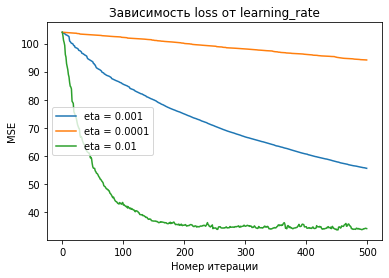

In [47]:
plt.title('Зависимость loss от learning_rate')
plt.xlabel('Номер итерации')
plt.ylabel('MSE')
for eta in etas:
    plt.plot(metrics_eta[eta]['reg'].loss_history, label='eta = {}'.format(eta))
plt.legend()

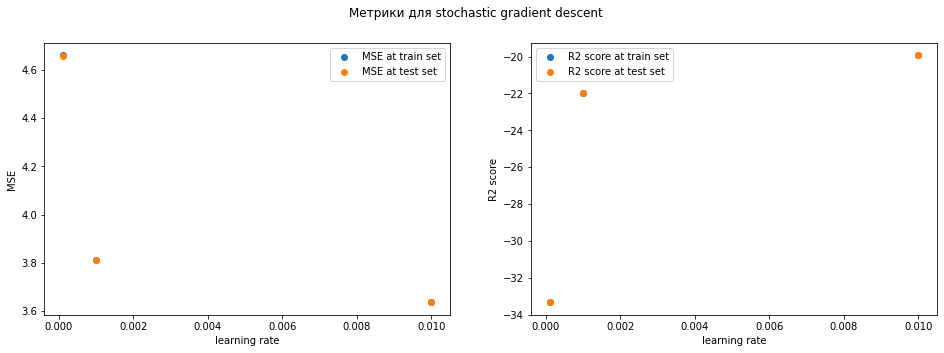

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

fig.suptitle('Метрики качества в зависимости от learning rate')

ax1.scatter(etas, [metrics_eta[eta]['train_rmse'] for eta in etas], label='MSE at train set')
ax1.scatter(etas, [metrics_eta[eta]['test_rmse'] for eta in etas], label='MSE at test set')
ax1.set_xlabel('learning rate')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.scatter(etas, [metrics_eta[eta]['train_r2'] for eta in etas], label='R2 score at train set')
ax2.scatter(etas, [metrics_eta[eta]['train_r2'] for eta in etas], label='R2 score at test set')
ax2.set_xlabel('learning rate')
ax2.set_ylabel('R2 score')
ax2.legend()

##### Как reg_coef влияет на метрики:

In [51]:
gd_type = 'stochastic'
max_iter = 500
w0 = np.random.random(X_train.shape[1])
eta = 1e-2
reg_coefs = np.array([0.5, 1, 2, 5, 10])
alpha = 0.0

In [52]:
metrics_reg_coef = dict()
for reg_coef in reg_coefs:
    metrics_reg_coef[reg_coef] = pipeline(gd_type, max_iter, w0, eta, reg_coef, alpha)

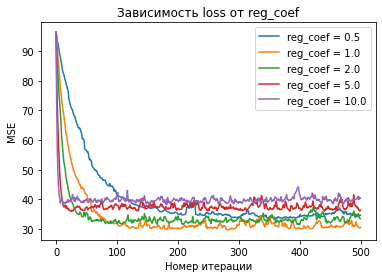

In [54]:
plt.title('Зависимость loss от reg_coef')
plt.xlabel('Номер итерации')
plt.ylabel('MSE')
for reg_coef in reg_coefs:
    plt.plot(metrics_reg_coef[reg_coef]['reg'].loss_history, label='reg_coef = {}'.format(reg_coef))
plt.legend()

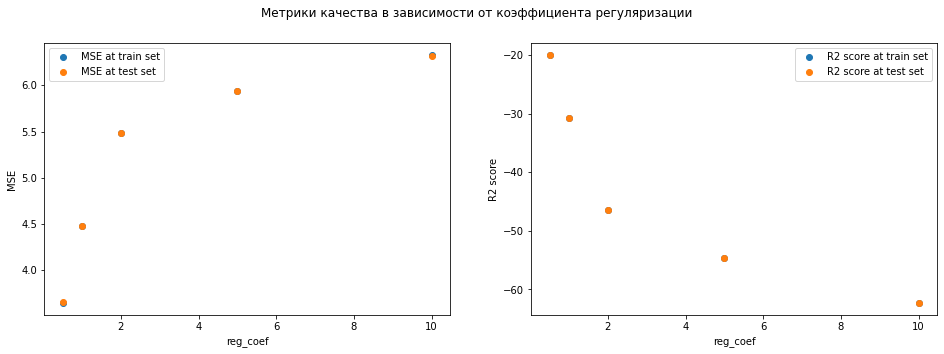

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

fig.suptitle('Метрики качества в зависимости от коэффициента регуляризации')

ax1.scatter(reg_coefs, [metrics_reg_coef[reg_coef]['train_rmse'] for reg_coef in reg_coefs], label='MSE at train set')
ax1.scatter(reg_coefs, [metrics_reg_coef[reg_coef]['test_rmse'] for reg_coef in reg_coefs], label='MSE at test set')
ax1.set_xlabel('reg_coef')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.scatter(reg_coefs, [metrics_reg_coef[reg_coef]['train_r2'] for reg_coef in reg_coefs], label='R2 score at train set')
ax2.scatter(reg_coefs, [metrics_reg_coef[reg_coef]['train_r2'] for reg_coef in reg_coefs], label='R2 score at test set')
ax2.set_xlabel('reg_coef')
ax2.set_ylabel('R2 score')
ax2.legend()

** Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [ ]:
w0 = np.random.random(X_train.shape[1])
clf_stoch = LinearReg(gd_type='stochastic', max_iter=500, w0=w0)
clf_stoch.fit(X_train, y_train)

clf_full = LinearReg(gd_type='full', max_iter=500, w0=w0)
clf_full.fit(X_train, y_train)

clf_momentum = LinearReg(gd_type='momentum', max_iter=500, w0=w0)
clf_momentum.fit(X_train, y_train)

In [ ]:
plt.plot(clf_stoch.loss_history, label='stochastic')
plt.plot(clf_full.loss_history, label='full')
plt.plot(clf_momentum.loss_history, label='momentum')
plt.title('Фунция потерь для разных видов градиентного спуска')
plt.ylabel('MSE')
plt.xlabel('Номер итерации')
plt.legend()

### Бонус 

** Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

** Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

** Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook